## Random Walk

In [27]:
'''
Generalized behavior for random walking, one grid cell at a time.
'''

import random

from mesa import Agent


class RandomWalker(Agent):
    '''
    Class implementing random walker methods in a generalized manner.
    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.
    '''

    #grid = None
    #x = None
    #y = None
    #moore = True

    def __init__(self, pos, model, moore=True):
        '''
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        '''
        Step one cell in any allowable direction.
        '''
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

## Schedule

In [28]:
from collections import defaultdict
from mesa.time import RandomActivation

class RandomActivationByBreed(RandomActivation):
    '''
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    This is equivalent to the NetLogo 'ask breed...' and is generally the
    default behavior for an ABM.
    Assumes that all agents have a step() method.
    '''
    agents_by_breed = defaultdict(list)

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(list)

    def add(self, agent):
        '''
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        '''

        self.agents.append(agent)
        agent_class = type(agent)
        self.agents_by_breed[agent_class].append(agent)

    def remove(self, agent):
        '''
        Remove all instances of a given agent from the schedule.
        '''

        while agent in self.agents:
            self.agents.remove(agent)

        agent_class = type(agent)
        while agent in self.agents_by_breed[agent_class]:
            self.agents_by_breed[agent_class].remove(agent)

    def step(self, by_breed=True):
        '''
        Executes the step of each agent breed, one at a time, in random order.
        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        '''
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        '''
        Shuffle order and run all agents of a given breed.
        Args:
            breed: Class object of the breed to run.
        '''
        agents = self.agents_by_breed[breed]
        random.shuffle(agents)
        for agent in agents:
            agent.step()

    def get_breed_count(self, breed_class):
        '''
        Returns the current number of agents of certain breed in the queue.
        '''
        return len(self.agents_by_breed[breed_class])

## Agents


In [34]:
class ResourcePatch(Agent):
    def _init_(self, unique_id, model):
        super()._init_(unique_id, model)

class Forager(RandomWalker): 
    
    verbose = False
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.energy_accum = 0
        self.success_count = 0
    
    def step(self):
        self.random_move()
        print(self.model.resource)
        print(self.pos)
        if self.model.resource:

            # exploit
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            resource_patch = [obj for obj in this_cell if isinstance(obj, ResourcePatch)][0]
            self.energy_accum = self.energy_accum + (10*(patch_size-foraging_time))-(patch_size-foraging_time)**2
            self.success_count = self.success_count + 1
            print('exploit')
            
            #deplete resource patch
            self.model.grid._remove_agent(ResourcePatch, self.pos)
            self.model.schedule.remove(ResourcePatch)
            
            #add new resource patch
            x,y = self.model.grid.find_empty()
            self.model.grid.place_agent(ResourcePatch, (x,y))
            self.model.schedule.add(ResourcePatch)
            
        else:
            #explore
            self.energy_accum = self.energy_accum - self.model.search_cost
            print('explore')
        
        print(self.unique_id)

## Model

In [35]:
from mesa import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

#width = 100
#height = 100
#N2 = 1
#energy_accum = 0  #energy accumulation to get a measure of energy intake
#success_count = 0 #times forager encounters a resource patch and exploits
#patch_density = .05 #proportion of patches that will contain resources
#num_patches = round((width*height)*patch_density) # (width*height)*patch_density
#patch_size = 10 #how much each resource patch can give ##to help model patch quality variability 
#search_cost = 1 #energy consumption when searching for patch
#foraging_time = 5 #how long forager stays in patch ##how many resource agents it eats in every patch

class MVT(Model):
    
    resource = False
    
    def __init__(self, num_patches, num_foragers, patch_size, search_cost, foraging_time, width, height,):
        self.num_patches = num_patches
        self.num_foragers = num_foragers
        self.patch_size = patch_size
        self.search_cost = search_cost
        self.foraging_time = foraging_time
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        
        for i in range(self.num_patches):
            a = ResourcePatch(i, self)
            self.schedule.add(a)
            # Add the resources to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            print('resource placed',i,'at',x,y)
            
        for j in range(self.num_foragers):
            b = Forager(j, self)
            self.schedule.add(b)
            # add the forager(s) to a random empty cell
            x,y = self.grid.find_empty()
            self.grid.place_agent(b, (x,y))
            print('agent placed',j,'at',x,y)
            
    def step(self):
           self.schedule.step() 
            
    def run_model(self, step_count=200):

        if self.verbose:
            print('Initial number resource patches: ',
                  self.schedule.get_breed_count(ResourcePatch))
            print('Initial number of foragers: ',
                  self.schedule.get_breed_count(Forager))

        for i in range(step_count):
            self.step()

        if self.verbose:
            print('')
            print('Final number resource patches: ',
                  self.schedule.get_breed_count(ResourcePatch))
            print('Final number foragers: ',
                  self.schedule.get_breed_count(Forager))

## Server



In [36]:
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule


def agent_portrayal(agent):
    #if agent is None:
     #   return
    portrayal = {"Shape": "circle",
                 "Filled": "true"}
    if type(agent) is resource:
        portrayal["Color"]="#00AA00"
        portrayal["Shape"]="rect"
        portrayal["Layer"] = 0
        portrayal["w"] = 1
        portrayal["h"] = 1
        
    elif type(agent) is forager:
        portrayal["Color"]="#666666"
        portrayal["Shape"]="circle"
        portrayal["r"] = 0.8
        portrayal["Layer"] = 1
        
        return portrayal
    
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MVT,
                       [grid],
                       "MVT",
                       {"num_patches": 75,"num_foragers":1 ,"patch_size": 10, "search_cost": 1, "foraging_time": 5,"width": 100, "height": 100})

resource placed 0 at 48 31
resource placed 1 at 39 17
resource placed 2 at 74 78
resource placed 3 at 75 38
resource placed 4 at 42 76
resource placed 5 at 38 66
resource placed 6 at 5 46
resource placed 7 at 90 32
resource placed 8 at 55 90
resource placed 9 at 46 18
resource placed 10 at 87 36
resource placed 11 at 45 36
resource placed 12 at 76 63
resource placed 13 at 45 49
resource placed 14 at 15 23
resource placed 15 at 42 25
resource placed 16 at 39 41
resource placed 17 at 53 87
resource placed 18 at 19 47
resource placed 19 at 53 14
resource placed 20 at 1 80
resource placed 21 at 69 34
resource placed 22 at 28 26
resource placed 23 at 9 59
resource placed 24 at 6 70
resource placed 25 at 45 62
resource placed 26 at 47 95
resource placed 27 at 13 36
resource placed 28 at 84 71
resource placed 29 at 72 18
resource placed 30 at 25 53
resource placed 31 at 42 72
resource placed 32 at 23 21
resource placed 33 at 62 56
resource placed 34 at 46 22
resource placed 35 at 60 57
resour

## Run

In [37]:
model = MVT(100,1,10,1,5,10,10)
for i in range(100):
    model.step()



resource placed 0 at 6 0
resource placed 1 at 1 1
resource placed 2 at 6 7
resource placed 3 at 7 7
resource placed 4 at 5 8
resource placed 5 at 0 3
resource placed 6 at 1 8
resource placed 7 at 4 3
resource placed 8 at 6 5
resource placed 9 at 9 6
resource placed 10 at 1 2
resource placed 11 at 3 4
resource placed 12 at 1 0
resource placed 13 at 9 1
resource placed 14 at 4 7
resource placed 15 at 3 6
resource placed 16 at 9 7
resource placed 17 at 9 0
resource placed 18 at 7 6
resource placed 19 at 0 8
resource placed 20 at 4 5
resource placed 21 at 1 1
resource placed 22 at 0 6
resource placed 23 at 2 5
resource placed 24 at 0 0
resource placed 25 at 6 6
resource placed 26 at 6 5
resource placed 27 at 9 6
resource placed 28 at 1 0
resource placed 29 at 4 5
resource placed 30 at 4 3
resource placed 31 at 9 0
resource placed 32 at 2 0
resource placed 33 at 6 0
resource placed 34 at 0 3
resource placed 35 at 4 7
resource placed 36 at 6 0
resource placed 37 at 9 6
resource placed 38 at 

In [45]:
server.port = 8522
server.launch()

Interface starting at http://127.0.0.1:8522
Socket opened!
{"type":"get_params"}
{"type":"reset"}


## Outputs

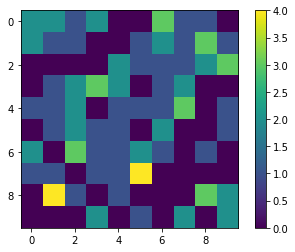

In [33]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [26]:
#agent_energy_accum = [b.success_count for b in model.schedule.agents]
#plt.hist(agent_energy_accum)
#[Forager.success_count for Forager in model.schedule.agents]
#model.schedule.agents

In [ ]:
##AGENT CONDITION SEEMS TO MAKE SENSE FOR EXPLOITING, MAYBE IT IS NOT MOVING CORRECTLY
##Resource distribution maybe doesnt work as expected